In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Common Windows encoding
df = pd.read_csv("dataset.csv", encoding="cp1252")

# first need to subset
counties = ["Los Angeles", "San Diego", "Orange", "Riverside", "San Bernardino"]

subset_df = df[df["County"].isin(counties)]

# get rid of the 30-day (done)
# remove location column (done)
# print unique types in hospital rating and see how many unique types, convert to like three of four (there is already three so this looks good)
# do something with the e's 
# Cleaning the Data

subset_df.loc[:, 'Measure'] = subset_df['Measure'].str.replace('30-day ', '')

subset_df.loc[:, '# of Cases'] = pd.to_numeric(subset_df['# of Cases'], errors='coerce')
subset_df.loc[:, '# of Deaths/Readmissions'] = pd.to_numeric(subset_df['# of Deaths/Readmissions'], errors='coerce')


In [42]:
subset_df=subset_df.loc[:, ['Year','County', 'Hospital','OSHPDID','Measure','Risk Adjusted Rate','# of Deaths/Readmissions','# of Cases','Hospital Ratings']]
subset_df['Hospital Ratings'].unique()
subset_df['Measure'].unique()

array(['Readmission', 'Mortality'], dtype=object)

In [43]:
subset_df['Start'] = subset_df['Year'].str.split('-').str[0]
subset_df['Year']=subset_df['Start']
subset_df = subset_df.drop('Start',axis=1)

subset_df['Year'] = pd.to_numeric(subset_df['Year'], errors='coerce')
subset_df.head()

,Year,County,Hospital,OSHPDID,Measure,Risk Adjusted Rate,# of Deaths/Readmissions,# of Cases,Hospital Ratings
92,2011,Los Angeles,Alhambra Hospital,106190017,Readmission,10.40,12.0,96.0,As Expected
93,2011,Los Angeles,Alhambra Hospital,106190017,Mortality,4.63,5.0,100.0,As Expected
94,2011,Los Angeles,Antelope Valley Hospital,106190034,Readmission,14.61,61.0,414.0,As Expected
95,2011,Los Angeles,Antelope Valley Hospital,106190034,Mortality,12.32,41.0,431.0,As Expected
96,2011,Los Angeles,Saint Mary Medical Center,106190053,Readmission,11.55,26.0,189.0,As Expected


In [44]:
X = subset_df

ddf = pd.get_dummies(X['Hospital Ratings'],dtype='int')
X['Hospital Ratings'] = X['Hospital Ratings'].fillna('Unknown')

from sklearn.preprocessing import LabelBinarizer

one_hot_encoder = LabelBinarizer()
oh = one_hot_encoder.fit_transform(X['Hospital Ratings']) # One-hot encode the 'bird' variable
#print(oh)
names = one_hot_encoder.classes_ # Get names of the classes
#print(names)

zdf = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
zdf.head()

,As Expected,Better,Unknown,Worse
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [45]:
ddf = pd.get_dummies(X['Measure'], dtype=int)
X['Measure'] = X['Measure'].fillna('Unknown')

X['Measure'] = X['Measure'].fillna('Unknown')
zdf = pd.get_dummies(X['Measure'], dtype=int)

zdf.head()

,Mortality,Readmission
92,0,1
93,1,0
94,0,1
95,1,0
96,0,1


In [46]:
y = subset_df['Hospital Ratings'] # Create target variable vector
X = subset_df.loc[:,['County','Risk Adjusted Rate','Year','# of Cases','# of Deaths/Readmissions']] # Create feature matrix
X.head()

,County,Risk Adjusted Rate,Year,# of Cases,# of Deaths/Readmissions
92,Los Angeles,10.40,2011,96.0,12.0
93,Los Angeles,4.63,2011,100.0,5.0
94,Los Angeles,14.61,2011,414.0,61.0
95,Los Angeles,12.32,2011,431.0,41.0
96,Los Angeles,11.55,2011,189.0,26.0


In [47]:
X = pd.get_dummies(X, drop_first=False)
bool_cols = [c for c in X.columns if X[c].dtype == bool]
X[bool_cols] = X[bool_cols].astype(int)

non_numeric = X.columns[X.dtypes == "object"]
print(non_numeric)


Index([], dtype='object')


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
print(X_train.shape)

(820, 9)


In [56]:
# Maxmin normalization function; Sci-kit calls it the "standard scaler"
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

mins = X_train.min() # I used Chat GPT to refine this section, it suggested not using the maxmin function and isntead doing this. 
maxs = X_train.max()

X_train_scaled = (X_train - mins) / (maxs - mins)
X_train_scaled = X_train_scaled.fillna(0) # used ChatGPT to fix some errors, 
X_test_scaled = (X_test - mins) / (maxs - mins)
X_test_scaled = X_test_scaled.fillna(0)


k_bar = 50 # Number of k's to try
SSE = [] # We'll store the SSE here 
SSE_on_train = [] # For pedogogical purposes, we'll save the training error

for k in range(k_bar):
    model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_scaled, y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_scaled)
    test_error = 1 - np.mean(y_hat == y_test)
    SSE.append(test_error) # Save the computed SSE for test set
    y_hat_train = fitted_model.predict(X_train_scaled)
    train_error = 1 - np.mean(y_hat_train == y_train)
    SSE_on_train.append(train_error) # Save the computed SSE

best_k = np.argmin(SSE) + 1
print("Best k:", best_k)

Best k: 1


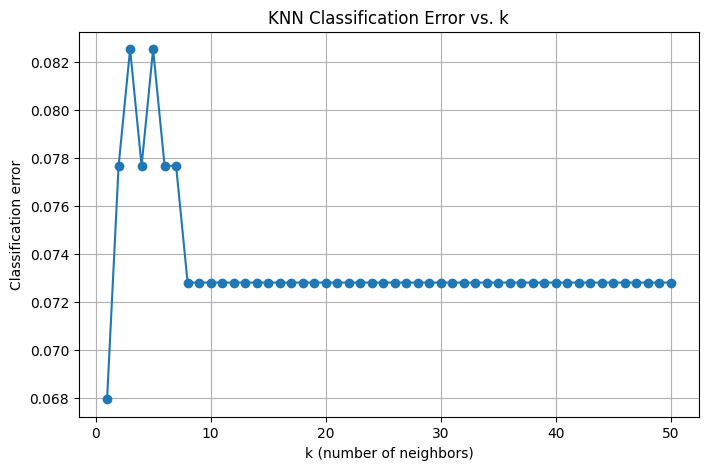

In [61]:
plt.figure(figsize=(8,5))
plt.plot(range(1, k_bar+1), SSE, marker='o')
plt.xlabel("k (number of neighbors)")
plt.ylabel("Classification error")
plt.title("KNN Classification Error vs. k")
plt.grid(True)
plt.show()


In [64]:
k = best_k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# used chatgpt to help display the results clearly 
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred)) <-- ChatGPT also suggested including this, but this was not familiar to what we had done in class

Accuracy: 0.9320388349514563

Confusion Matrix:
 [[189   2   0   0]
 [  6   1   0   0]
 [  1   0   0   0]
 [  5   0   0   2]]
